In [189]:
from netgen.meshing import *
from ngsolve import *
from netgen.meshing import Mesh as NGMesh
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry, unit_square
import matplotlib.pyplot as plt
import numpy as np
import pickle
from ngsolve import CoefficientFunction

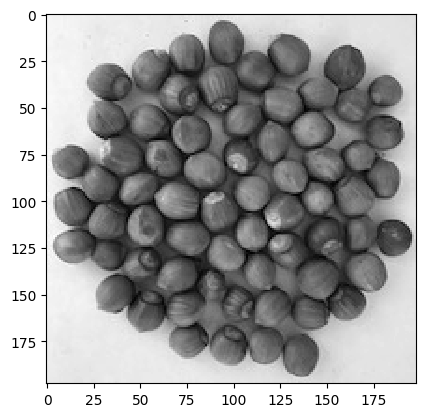

In [190]:
with open('img.pkl','rb') as fp:
    img = pickle.load(fp)
plt.imshow(img,interpolation='none', cmap='gray')


In [191]:
# Define the number of elements in each direction
nx = int((img.shape[0]-1)/1)
ny = int((img.shape[1]-1)/1)

# Create a SplineGeometry object
geom = SplineGeometry()

# Add points to the geometry
p1 = geom.AppendPoint(0, 0)
p2 = geom.AppendPoint(1, 0)
p3 = geom.AppendPoint(1, 1)
p4 = geom.AppendPoint(0, 1)

# Add lines to the geometry
geom.Append(["line", p1, p2], bc="bottom")
geom.Append(["line", p2, p3], bc="right")
geom.Append(["line", p3, p4], bc="top")
geom.Append(["line", p4, p1], bc="left")

# Generate the mesh
mesh = Mesh(geom.GenerateMesh(maxh=1.0/min(nx, ny)))


In [192]:
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [193]:
# Gegeben aus Aufgabenstellung:
t0 = 0
dt = 0.1
tend = 2
eps0 = 1e-4

# parameter initialization
t = Parameter (t0)
eps = Parameter (eps0)

In [194]:
# FEM Raum => Annahme Order = 2
V = H1(mesh, order=2)

# Trial Funktion
u = V.TrialFunction()
# Test Funktion 
v = V.TestFunction()

gfu = GridFunction(V)

a = BilinearForm (V, symmetric = False)
a += Variation((eps/2*grad(u)*grad(u) 
               +(u**2*(1-u*u)**2)
               + 0.5/dt*(u-gfu)**2)*dx)

In [195]:
a.AssembleLinearization(gfu.vec)

In [196]:
img_array = np.array(img)
print(img_array.shape)
print(img_array)

(198, 198)
[[0.9161449  0.9161449  0.90608515 ... 0.74423073 0.73417098 0.73417098]
 [0.92620466 0.9161449  0.90608515 ... 0.74423073 0.74423073 0.73417098]
 [0.92620466 0.9161449  0.9161449  ... 0.75429049 0.74423073 0.74423073]
 ...
 [0.83066616 0.83066616 0.8206064  ... 0.74854435 0.74854435 0.7384846 ]
 [0.83066616 0.83066616 0.8206064  ... 0.74854435 0.7384846  0.7384846 ]
 [0.83066616 0.8206064  0.8206064  ... 0.7384846  0.7384846  0.7384846 ]]


In [197]:
print(img_array[100, 100])
print(np.min(img_array))    # check if the image is normalized from -1 to 1
print(np.max(img_array))

-0.655624408989397
-1.0
1.0


Das Bild enthält Werte zwischen -1 und 1, das ist ideal für unsere Anwendung. Wir werden deshalb nichts normalisieren müssen.

In [198]:
u0 = img_array

In [199]:
cfImg = VoxelCoefficient((0,0),(1,1),
                         img[np.arange(img.shape[0]-1,-1,-1)])
Draw(cfImg,mesh,'cfImg')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [200]:
# Convert numpy array to list
u0_list = u0.tolist()

# Create CoefficientFunction from list
u0_cf = CoefficientFunction(u0_list)

# Now you can set the GridFunction
#gfu.Set(u0_cf)
gfu.Set(cfImg)

In [201]:
res = gfu.vec.CreateVector()
du = gfu.vec.CreateVector()

In [202]:
InnerProduct(du,res)

0.0

In [203]:
# Convert GridFunction to numpy array
gfu_array = gfu.vec.FV().NumPy()

gfu_array_t0 = gfu_array.copy()

# Print the minimum and maximum values of the GridFunction
print(np.min(gfu_array), np.max(gfu_array))

-2.6514588030539104 3.683734796378884


In [204]:
# Newton Verfahren:
for it in range(int((tend-t0)/dt)):
    print("Newton iteration", it)

    # solve linearized problem:
    # F(u_n)
    a.Apply (gfu.vec, res)

    # F'(u_n)
    a.AssembleLinearization(gfu.vec)
    # TODO: Alternativ die selber berechnete variation (a1) verwenden mit:
    #a1.Assemble()

    du.data = a.mat.Inverse(V.FreeDofs()) * res
    # TODO: alternativ selber berechnete variation verwenden mit:
    #du.data = a1.mat.Inverse(V.FreeDofs()) * res

    # update interation
    # u_n+1 = u_n - du
    gfu.vec.data -= du

    # change value of eps based on time passed
    #eps.Set(eps0- eps0/((tend-t0)/dt)*it)
    eps.Set(0)
    print("eps:", eps.Get())

    """
    #stop after 2 seconds
    print(t.Get())
    if t >= tend:
        break
    """
    
    t.Set(t.Get()+dt)
    print("Seconds passed: ", t.Get())
    
    #stopping criteria
    stopcritval = sqrt(abs(InnerProduct(du,res)))
    print ("<A u",it,", A u",it,">_{-1}A0.S = ", stopcritval)
    print(gfu)
    if stopcritval < 1e-13:
        break

Newton iteration 0
eps: 0.0
Seconds passed:  0.1
<A u 0 , A u 0 >_{-1}A0.S =  0.22891329989048415
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 1
eps: 0.0
Seconds passed:  0.2
<A u 1 , A u 1 >_{-1}A0.S =  0.11103166207228223
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 2
eps: 0.0
Seconds passed:  0.30000000000000004
<A u 2 , A u 2 >_{-1}A0.S =  0.10299651102939399
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 3
eps: 0.0
Seconds passed:  0.4
<A u 3 , A u 3 >_{-1}A0.S =  0.09291677954459189
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 4
eps: 0.0
Seconds passed:  0.5
<A u 4 , A u 4 >_{-1}A0.S =  0.08336687352347913
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 5
eps: 0.0
Seconds passed:  0.6
<A u 5 , A u 5 >_{-1}A0.S =  0.0748

In [205]:
Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [206]:
# Convert GridFunction to numpy array
gfu_array_2s = gfu.vec.FV().NumPy()

# Print the minimum and maximum values of the GridFunction
print(np.min(gfu_array_2s), np.max(gfu_array_2s))

-5.949453944723192 10.0853955807288


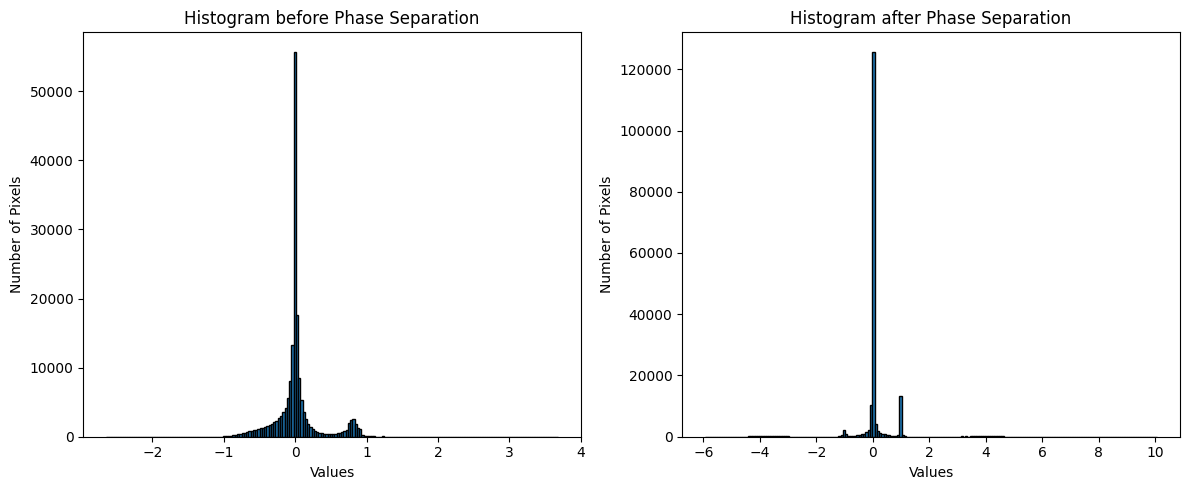

In [207]:
# Set a higher resolution for bins
num_bins = 200

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first histogram
axs[0].hist(gfu_array_t0, bins=num_bins, edgecolor='black')
#axs[0].set_yscale('log')  # Set y-axis scale to logarithmic
axs[0].set_title('Histogram before Phase Separation')
axs[0].set_xlabel('Values')
axs[0].set_ylabel('Number of Pixels')

# Plot the second histogram
axs[1].hist(gfu_array_2s, bins=num_bins, edgecolor='black')
#axs[1].set_yscale('log')  # Set y-axis scale to logarithmic
axs[1].set_title('Histogram after Phase Separation')
axs[1].set_xlabel('Values')
axs[1].set_ylabel('Number of Pixels')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

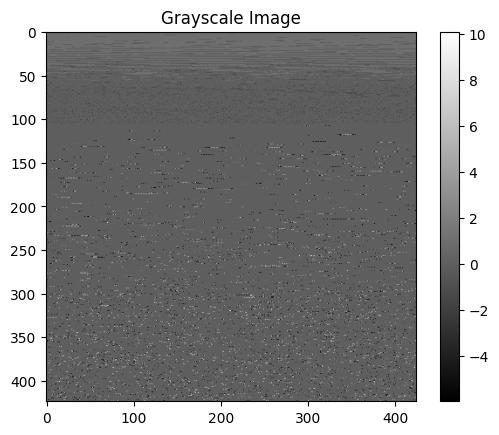

In [208]:
size = int(np.sqrt(len(gfu_array_2s)))
gfu_array_2s_reshaped = gfu_array_2s[:size**2].reshape((size, size))

plt.imshow(gfu_array_2s_reshaped, cmap='gray')
plt.colorbar()  # Optionally, you can add a colorbar to show intensity values
plt.title('Grayscale Image')
plt.show()